In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from quantum_code import *
from utils import get_logicals
import stim
from scipy.sparse import lil_matrix
import scipy as sp
from ldpc import bposd_decoder, bp_decoder
from tqdm import tqdm
from result_lifetime import Result, save_new_res
# %load_ext snakeviz

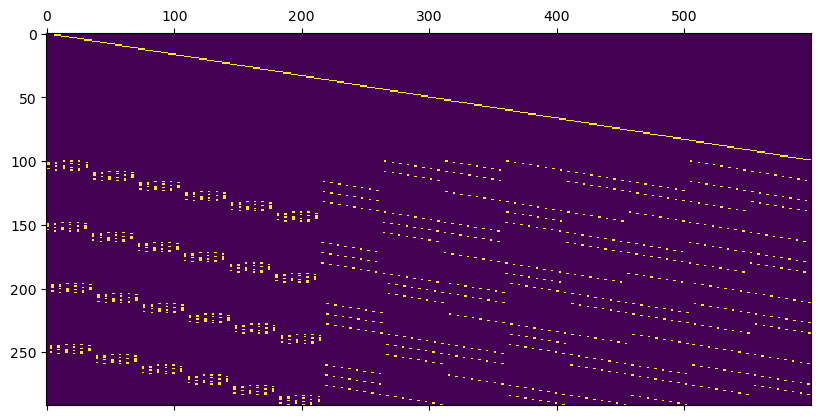

In [51]:
qcode = read_qcode("./codes/qcodes/HGP_C422_900_18.qcode")
qcode = read_qcode("./codes/qcodes/HGP_C642_600_16.qcode")

# qcode = read_qcode("./codes/qcodes/HGP_900_36.qcode")

# qcode = read_qcode("./codes/qcodes/HGP_Surface_1300_4.qcode")

Hx, Hz, Lx, Lz = qcode.to_numpy()

plt.matshow(Hx)

In [52]:
overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
# for i in range(concatenatedStabilizersQED.shape[0]):
#     tmp = np.array([], dtype=int)
#     for j in range(concatenatedStabilizersZQEC.shape[0]):
#         if np.any(concatenatedStabilizersQED[i] & concatenatedStabilizersZQEC[j]): tmp = np.append(tmp, j+concatenatedStabilizersQED.shape[0])
#     overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure))
    else:
        return np.array(list(gens_to_measure))

In [142]:
qubit_error_rate = 0.001
meas_error_rate = 0.001

if (qcode.qedxm):
    bp_qed_dec = bp_decoder(
        Hx[:qcode.qedxm], # the parity check matrix
        error_rate=qubit_error_rate,
        # channel_probs=new_channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
        max_iter=100, #pcm.shape[1], #the maximum number of iterations for BP)
        bp_method="msl",
        ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
        # osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
        # osd_order=40 #the osd search depth
    )

bposd_qed_qec_dec = bposd_decoder(
    Hx,
    error_rate=qubit_error_rate,
    bp_method="msl",
    max_iter=Hx.shape[1],
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=40 #the osd search depth
)

bposd_qec_dec = bposd_decoder(
    Hx,
    error_rate=qubit_error_rate,
    # channel_probs=Hx.shape[1]*[qubit_error_rate],
    bp_method="msl",
    max_iter=Hx.shape[1],
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=4 #the osd search depth
)

In [145]:
concat = 0
adaptive = 0

# num_gens_measured = []

rs = []
tmp = []
for ii in tqdm(range(1,1001)):
    num_rounds = 0
    residual_error = np.zeros(Hx.shape[1], dtype=int)

    while True:
        num_rounds += 1
        new_qubit_error = np.random.choice([0, 1], size=Hx.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=Hx.shape[0], p=[1-meas_error_rate, meas_error_rate])
        curr_qubit_error = residual_error ^ new_qubit_error
        curr_synd = ((Hx @ curr_qubit_error) % 2) ^ new_synd_error

        # QEC
        if (concat == 0 and adaptive == 0):
            guessed_error = bposd_qec_dec.decode(curr_synd)
        elif (concat == 1):
            # QED + QEC
            _ = bp_qed_dec.decode(curr_synd[:qcode.qedxm])

            ######################## # THIS MIGHT NEED TO CHANGE SLIGHTLY, SOFT INFORMATION DECODING
            # new_channel_probs = np.exp(-bp_qed_dec.log_prob_ratios)
            new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
            new_channel_probs = new_channel_probs / np.sum(new_channel_probs) / num_rounds
            # new_channel_probs[400:] = meas_error_rate
            bposd_qed_qec_dec.update_channel_probs(new_channel_probs)
            ########################

            updated_synd = curr_synd.copy()
            if (adaptive == 1):
                non_overlapping_gens = get_overlapping(curr_synd[:qcode.qedxm], True, True)
                # num_gens_measured.append(qcode.xm - len(non_overlapping_gens))
                updated_synd[non_overlapping_gens] = 0

            guessed_error = bposd_qed_qec_dec.decode(updated_synd)

        residual_error = curr_qubit_error ^ guessed_error
        ideal_correction = bposd_qec_dec.decode((Hx @ residual_error) % 2)

        # obs = [np.count_nonzero(residual_error[l]) % 2 for l in zL_inds]
        obs = [np.count_nonzero((ideal_correction ^ residual_error)[l]) % 2 for l in qcode.Lz]

        if np.any(obs):
            break

    res = Result(concat, adaptive, qcode.n, qcode.k, qubit_error_rate, meas_error_rate, 1, num_rounds, 0)
    rs.append(res)
    tmp.append(num_rounds)

    if (ii%10==0):
        save_new_res('tmp.res', rs)
        rs = []
print(np.mean(tmp))

  6%|▋         | 63/1000 [01:18<19:29,  1.25s/it]


KeyboardInterrupt: 

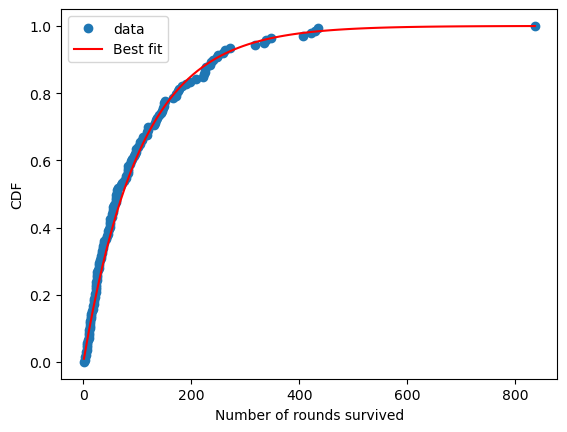

105.15714285714286


In [141]:
x = tmp
_, best_lifetime = sp.stats.expon.fit(x, floc=0)

x_interp = np.linspace(min(x), max(x), 100)
plt.plot(np.sort(x), np.linspace(0, 1, len(x)), 'o', label='data')
plt.plot(x_interp, sp.stats.expon.cdf(x_interp, scale=best_lifetime), 'r-', label='Best fit')
plt.legend()
plt.xlabel('Number of rounds survived')
plt.ylabel('CDF')
plt.show()

print(best_lifetime)

In [122]:
# Seed the random number generator.
rng = np.random.default_rng(0)

# Number of boostrap resampling fits.
n_bs = 100

resampled_lifetimes = np.zeros(shape=n_bs)
for i in range(n_bs):
    x_resamp = rng.choice(x, size=len(x))
    _, lifetime = sp.stats.expon.fit(x_resamp, floc=0)
    resampled_lifetimes[i] = lifetime

# 2-sigma confidence intervals
lifetime_lower = np.quantile(resampled_lifetimes, 0.025)
lifetime_upper = np.quantile(resampled_lifetimes, 0.975)

print(lifetime_lower, best_lifetime, lifetime_upper)

87.38493975903614 97.78313253012048 106.93092369477911


In [91]:
successes = 0
successes2 = 0

for ii in range(1,10001):
    if (ii % 1000 == 0): print('*', end='')
    residual_error = np.zeros(Hx.shape[1], dtype=int)

    success = 1
    success2 = 1
    for jj in range(2):
        new_qubit_error = np.random.choice([0, 1], size=Hx.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=Hx.shape[0], p=[1-meas_error_rate, meas_error_rate])
        curr_qubit_error = residual_error ^ new_qubit_error
        curr_synd = ((Hx @ curr_qubit_error) % 2) ^ new_synd_error

        # QEC
        guessed_error = bposd_qec_dec.decode(curr_synd)

        # QED + QEC
        initial_guess = bp_qed_dec.decode(curr_synd[:100])

        # ########################
        # new_channel_probs = np.exp(-bp_qed_dec.log_prob_ratios) # THIS MIGHT NEED TO CHANGE SLIGHTLY
        # new_channel_probs = new_channel_probs / np.sum(new_channel_probs)
        new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
        new_channel_probs = new_channel_probs / np.sum(new_channel_probs)
        # new_channel_probs[400:] = meas_error_rate
        bposd_qed_qec_dec.update_channel_probs(new_channel_probs)
        # ########################

        updated_synd = curr_synd.copy()
        updated_synd[get_overlapping(curr_synd[:qcode.qedxm], True, True)] = 0

        guessed_error2 = bposd_qed_qec_dec.decode(updated_synd)

        residual_error = curr_qubit_error ^ guessed_error
        residual_error2 = curr_qubit_error ^ guessed_error2


    # print()
    obs = [np.count_nonzero(residual_error[l]) % 2 for l in qcode.Lz]
    obs2 = [np.count_nonzero(residual_error2[l]) % 2 for l in qcode.Lz]

    if np.any(obs2):
        success2 = 0
    if np.any(obs):
        success = 0

    successes += success
    successes2 += success2

print()
print(successes, successes2)

**********
9215 9195


In [74]:
residual_error = np.zeros(Hx.shape[1], dtype=int)

new_qubit_error = np.random.choice([0, 1], size=Hx.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
new_synd_error = np.random.choice([0, 1], size=Hx.shape[0], p=[1-meas_error_rate, meas_error_rate])
curr_qubit_error = residual_error ^ new_qubit_error
curr_synd = ((Hx @ curr_qubit_error) % 2) ^ new_synd_error

print(np.where(curr_qubit_error))
# QEC
# guessed_error = bposd_qec_dec.decode(curr_synd)

# QED + QEC
initial_guess = bp_qed_dec.decode(curr_synd[:qcode.qedxm])

# ########################
# # new_channel_probs = np.exp(-bp_qed_dec.log_prob_ratios) # THIS MIGHT NEED TO CHANGE SLIGHTLY
# # new_channel_probs = new_channel_probs / np.sum(new_channel_probs)
# new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
# # new_channel_probs = new_channel_probs / np.sum(new_channel_probs)
# # new_channel_probs[400:] = meas_error_rate
# bp_qed_qec_dec.update_channel_probs(new_channel_probs)

(array([], dtype=int64),)


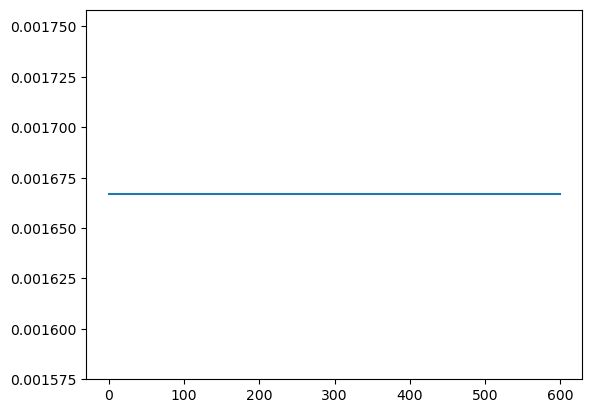

In [75]:
new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
new_channel_probs = new_channel_probs / np.sum(new_channel_probs)
plt.plot(new_channel_probs)